In [11]:
%load_ext autoreload
%env PYTHONUNBUFFERED True
%env CUDA_VISIBLE_DEVICES 0
import sys 
from os.path import dirname 
sys.path.append("tools/")

env: PYTHONUNBUFFERED=True
env: CUDA_VISIBLE_DEVICES=0


In [12]:
import _init_paths
import os
import random
import numpy as np
import yaml
import copy
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from datasets.linemod.dataset import PoseDataset as PoseDataset_linemod
from lib.network import PoseNet, PoseRefineNet
from lib.loss import Loss
from lib.loss_refiner import Loss_refine
from lib.transformations import euler_matrix, quaternion_matrix, quaternion_from_matrix
from lib.knn.__init__ import KNearestNeighbor




In [13]:
opt_dataset_root = "./datasets/linemod/Linemod_preprocessed"
opt_model = "trained_models/linemod/pose_model_9_0.012956139583687484.pth"
opt_refine_model = "trained_models/linemod/pose_refine_model_95_0.007274364822843561.pth"

num_objects = 13
objlist = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
num_points = 500
iteration = 4
bs = 1
dataset_config_dir = 'datasets/linemod/dataset_config'
output_result_dir = 'experiments/eval_result/linemod'
knn = KNearestNeighbor(1)




In [14]:
estimator = PoseNet(num_points = num_points, num_obj = num_objects)
estimator.cuda()
refiner = PoseRefineNet(num_points = num_points, num_obj = num_objects)
refiner.cuda()
estimator.load_state_dict(torch.load(opt_model))
refiner.load_state_dict(torch.load(opt_refine_model))
estimator.eval()
refiner.eval()

testdataset = PoseDataset_linemod('eval', num_points, False, opt_dataset_root, 0.0, True)
testdataloader = torch.utils.data.DataLoader(testdataset, batch_size=1, shuffle=False, num_workers=0) #Change me back

sym_list = testdataset.get_sym_list()
num_points_mesh = testdataset.get_num_points_mesh()
criterion = Loss(num_points_mesh, sym_list)
criterion_refine = Loss_refine(num_points_mesh, sym_list)

diameter = []
meta_file = open('{0}/models_info.yml'.format(dataset_config_dir), 'r')
meta = yaml.load(meta_file)
for obj in objlist:
    diameter.append(meta[obj]['diameter'] / 1000.0 * 0.1)
print(diameter)

success_count = [0 for i in range(num_objects)]
num_count = [0 for i in range(num_objects)]
fw = open('{0}/eval_result_logs.txt'.format(output_result_dir), 'w')


Object 1 buffer loaded
Object 2 buffer loaded
Object 4 buffer loaded
Object 5 buffer loaded
Object 6 buffer loaded
Object 8 buffer loaded
Object 9 buffer loaded
Object 10 buffer loaded
Object 11 buffer loaded
Object 12 buffer loaded
Object 13 buffer loaded
Object 14 buffer loaded
Object 15 buffer loaded
[0.010209865663, 0.024750624233, 0.017249224865, 0.020140358597000002, 0.015454551808, 0.026147178102, 0.010899920102000001, 0.016462758847999998, 0.017588933422000002, 0.014554287471000002, 0.027807811733, 0.028260129399, 0.021235825148]


In [93]:
model_points

array([[-0.0230565,  0.0174191, -0.006756 ],
       [-0.0155252,  0.0184487, -0.043124 ],
       [ 0.0215414, -0.0003537,  0.0175695],
       ...,
       [-0.0363434,  0.0035701, -0.0303421],
       [ 0.0093916,  0.0190458, -0.0419907],
       [ 0.0170096, -0.0095687,  0.01625  ]], dtype=float32)

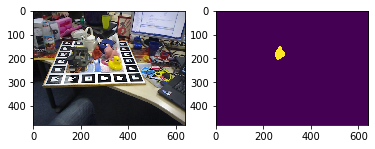

In [165]:
%matplotlib inline
from  visualization import Visualizer
import matplotlib.pyplot as plt
test1 = Visualizer(testdataset)

fig, ax = plt.subplots(1,2)
ax[0].imshow(test1.RGB(0))
ax[1].imshow(test1.True_Mask(0))




In [89]:
    pred_r, pred_t, pred_c, emb = estimator(img, points, choose, idx)
    pred_r = pred_r / torch.norm(pred_r, dim=2).view(1, num_points, 1)
    pred_c = pred_c.view(bs, num_points)
    how_max, which_max = torch.max(pred_c, 1)
    pred_t = pred_t.view(bs * num_points, 1, 3)

    my_r = pred_r[0][which_max[0]].view(-1).cpu().data.numpy()
    my_t = (points.view(bs * num_points, 1, 3) + pred_t)[which_max[0]].view(-1).cpu().data.numpy()
    my_pred = np.append(my_r, my_t)

    for ite in range(0, iteration):
        T = Variable(torch.from_numpy(my_t.astype(np.float32))).cuda().view(1, 3).repeat(num_points, 1).contiguous().view(1, num_points, 3)
        my_mat = quaternion_matrix(my_r)
        R = Variable(torch.from_numpy(my_mat[:3, :3].astype(np.float32))).cuda().view(1, 3, 3)
        my_mat[0:3, 3] = my_t
        
        new_points = torch.bmm((points - T), R).contiguous()
        pred_r, pred_t = refiner(new_points, emb, idx)
        pred_r = pred_r.view(1, 1, -1)
        pred_r = pred_r / (torch.norm(pred_r, dim=2).view(1, 1, 1))
        my_r_2 = pred_r.view(-1).cpu().data.numpy()
        my_t_2 = pred_t.view(-1).cpu().data.numpy()
        my_mat_2 = quaternion_matrix(my_r_2)
        my_mat_2[0:3, 3] = my_t_2

        my_mat_final = np.dot(my_mat, my_mat_2)
        my_r_final = copy.deepcopy(my_mat_final)
        my_r_final[0:3, 3] = 0
        my_r_final = quaternion_from_matrix(my_r_final, True)
        my_t_final = np.array([my_mat_final[0][3], my_mat_final[1][3], my_mat_final[2][3]])

        my_pred = np.append(my_r_final, my_t_final)
        my_r = my_r_final
        my_t = my_t_final

    # Here 'my_pred' is the final pose estimation result after refinement ('my_r': quaternion, 'my_t': translation)

    model_points = model_points[0].cpu().detach().numpy()
    my_r = quaternion_matrix(my_r)[:3, :3]
    pred = np.dot(model_points, my_r.T) + my_t

In [108]:
from dataset_debug import dataset
testing = dataset('eval', num_points, False, opt_dataset_root, 0.0, True)


Object 1 buffer loaded
Object 2 buffer loaded
Object 4 buffer loaded
Object 5 buffer loaded
Object 6 buffer loaded
Object 8 buffer loaded
Object 9 buffer loaded
Object 10 buffer loaded
Object 11 buffer loaded
Object 12 buffer loaded
Object 13 buffer loaded
Object 14 buffer loaded
Object 15 buffer loaded


In [88]:
a = (img.cpu()).squeeze()
test1.RGB(0)
#plt.imshow(a, rgb=)

(480, 640, 3)

In [100]:
obj = testdataset.list_obj[10]
rank = testdataset.list_rank[10]  


In [106]:
import numpy.ma as ma
ma.getmaskarray(ma.masked_equal(label, np.array(255)))
test1 = testdataset.get_bbox(mask_to_bbox(mask_label))

13407

In [158]:
    # try to visualize
cam_cx = 325.26110
cam_cy = 242.04899
cam_fx = 572.41140
cam_fy = 573.57043
K = np.array([[cam_fx,0,cam_cx],[0,cam_fy,cam_cy],[0,0,1]])



In [209]:
res = np.dot(K,pred.T)
points = res.T[:,[0,1]]
points = np.floor(points).astype(int)
firstPoint = np.squeeze(points[1])
firstPoint = tuple(firstPoint)
for pt in points: 
    print(tuple(pt))

(287, 178)
(293, 201)
(262, 171)
(278, 202)
(284, 191)
(290, 196)
(280, 201)
(291, 197)
(281, 199)
(293, 200)
(294, 198)
(290, 201)
(295, 199)
(273, 208)
(287, 197)
(286, 189)
(282, 180)
(265, 167)
(259, 182)
(288, 183)
(278, 204)
(264, 203)
(277, 208)
(285, 200)
(277, 198)
(277, 188)
(275, 182)
(273, 182)
(257, 182)
(258, 169)
(250, 180)
(250, 184)
(248, 185)
(270, 202)
(263, 202)
(285, 171)
(267, 162)
(273, 161)
(291, 191)
(289, 202)
(254, 198)
(248, 186)
(247, 183)
(285, 204)
(274, 188)
(270, 184)
(257, 166)
(256, 171)
(269, 162)
(274, 167)
(259, 158)
(260, 164)
(259, 162)
(261, 155)
(262, 163)
(269, 154)
(266, 175)
(258, 170)
(258, 171)
(278, 183)
(279, 185)
(284, 177)
(275, 204)
(258, 198)
(270, 177)
(271, 176)
(270, 173)
(275, 171)
(277, 164)
(266, 158)
(273, 157)
(281, 173)
(285, 173)
(296, 197)
(280, 169)
(274, 180)
(273, 184)
(282, 172)
(280, 173)
(291, 180)
(276, 164)
(289, 174)
(291, 187)
(297, 194)
(295, 188)
(297, 191)
(295, 199)
(274, 175)
(264, 175)
(271, 173)
(284, 192)

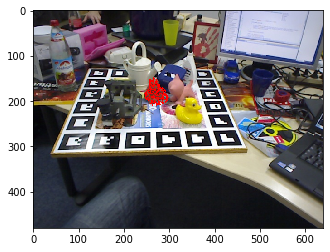

In [210]:
import cv2
a = test1.RGB(0)
for pt in points:
    pt = tuple(pt)
    cv2.circle(a,pt,1,[255,0,0],1)
plt.imshow(a)


In [170]:
test1.RGB(0)

array([[[ 33,  37,  48],
        [ 35,  39,  50],
        [ 37,  40,  49],
        ...,
        [172, 175, 192],
        [172, 175, 192],
        [171, 174, 191]],

       [[ 31,  35,  46],
        [ 32,  36,  45],
        [ 34,  37,  46],
        ...,
        [172, 175, 192],
        [172, 175, 192],
        [171, 174, 191]],

       [[ 32,  35,  44],
        [ 32,  35,  42],
        [ 31,  34,  41],
        ...,
        [173, 176, 193],
        [170, 176, 192],
        [170, 176, 192]],

       ...,

       [[ 36,  42,  56],
        [ 38,  44,  58],
        [ 40,  48,  61],
        ...,
        [ 79,  71,  60],
        [ 79,  70,  61],
        [ 83,  74,  65]],

       [[ 36,  44,  55],
        [ 37,  45,  56],
        [ 39,  47,  58],
        ...,
        [ 79,  71,  58],
        [ 77,  69,  58],
        [ 81,  73,  62]],

       [[ 37,  45,  56],
        [ 38,  46,  57],
        [ 39,  47,  58],
        ...,
        [ 80,  73,  57],
        [ 79,  71,  58],
        [ 80,  72,  59]]